In [1]:
import numpy as np
import scipy.stats as stats
import scipy.sparse as sparse
import itertools

#training patterns
P = 100
N=5
S=np.random.randint(0, 2, size=(P, N))*2-1




def generateInput(beta, n, pz):
    rvs = stats.norm().rvs
    X = sparse.random(n, n, density=pz, data_rvs=rvs)
    upper_X = sparse.triu(X) 
    result = upper_X + upper_X.T - sparse.diags(X.diagonal()) - sparse.diags(X.diagonal())
    result = result.toarray()
    result = np.array(result) #Frustrated result
    for i in range(n):
      for j in range(n):
        result[i,j] = beta * ((result[i,j]>0).astype('int') - (result[i,j]<0).astype('int'))
    return result

def s_all(n):
  return np.array(list(itertools.product([-1, 1], repeat=n)))


# compute clamped statistics from the data (using value of P)
def clamped_statistics(P,S):
  ress=0
  ss=0
  onesvec = np.ones(P)
  ress=np.dot(onesvec,S)
  for u in range(P):
    S1=np.array([S[u]])
    S2=np.array([S[u]]).T
    ss+= np.dot(S2,S1)
  ss = ss/P
  ress= ress/P
  return [ress,ss]



#
def free_statistics(w,th,N,S):
  result=0
  # p=np.zeros([N^2])
  p=np.array([])
  s_al =s_all(N)

  # compute the probabilities of each state
  for ps in s_al:
    subresult=0
    ps=np.array(ps)
    thetaterm=np.dot(th,ps)
    wterm=np.dot(ps,np.dot(w,ps))/2
    expterm=np.exp(wterm+thetaterm)
    
    p=np.append(p,expterm)

  #normalize probabilities
  p=p/sum(p)


 # compute the <s_i>
  ress=0
  ress1=np.ones(N)
  
  for i in range(N):
    iter=0
    ress=0
    for ps in s_al:
      ress+=p[iter]*ps[i]
      iter +=1
    #place result for s_i in vector
    ress1[i]=ress

  #compute the <s_i Ss_j>
  ress2=np.ones([N,N])
  for i in range(N):
    for j in range(N):
      iter=0
      ress=0
      for ps in s_al:
        ress+=p[iter]*ps[i]*ps[j]
        iter +=1
      #place result for s_i * s_j in matrix
      ress2[i][j]=ress


  return [ress1,ress2]

A = (clamped_statistics(P,S));

theta=np.ones(N)
w=np.random.random([N,N])*2-1
#tests
#theta=np.zeros(N)
w=np.ones([N,N])


print("free test")
B = free_statistics(w,theta,N,S)
print("clamped")
print(S)
print(A[0])
print(A[1])
print(B[0])
print(B[1])


free test
clamped
[[-1 -1  1 -1 -1]
 [-1  1  1  1  1]
 [-1 -1  1 -1  1]
 [ 1 -1 -1 -1  1]
 [ 1  1 -1 -1  1]
 [ 1  1 -1  1  1]
 [ 1  1  1 -1 -1]
 [ 1 -1 -1 -1  1]
 [-1 -1  1  1  1]
 [ 1  1  1 -1 -1]
 [-1  1  1 -1  1]
 [ 1  1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1]
 [-1  1  1  1  1]
 [ 1  1 -1 -1  1]
 [ 1  1 -1  1 -1]
 [-1 -1  1 -1  1]
 [-1  1 -1 -1 -1]
 [-1  1 -1  1 -1]
 [ 1  1 -1  1 -1]
 [-1 -1  1  1 -1]
 [ 1 -1  1  1  1]
 [-1  1 -1  1  1]
 [ 1  1  1  1  1]
 [-1 -1  1  1 -1]
 [-1  1 -1 -1 -1]
 [-1  1 -1  1 -1]
 [-1  1 -1  1  1]
 [-1 -1  1  1  1]
 [-1 -1 -1  1  1]
 [ 1  1  1 -1  1]
 [-1  1  1  1  1]
 [ 1  1 -1  1 -1]
 [-1 -1 -1  1 -1]
 [-1  1 -1 -1 -1]
 [-1  1 -1  1  1]
 [-1  1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]
 [-1  1 -1  1  1]
 [ 1 -1 -1 -1 -1]
 [ 1  1 -1 -1  1]
 [-1 -1 -1 -1  1]
 [-1 -1 -1 -1  1]
 [-1 -1  1  1 -1]
 [ 1  1  1 -1  1]
 [-1 -1  1 -1 -1]
 [ 1 -1  1  1  1]
 [-1  1  1  1 -1]
 [-1  1 -1  1 -1]
 [-1  1 -1  1 -1]
 [-1 -1 -1 -1  1]
 [-1 -1  1  1  1]
 [ 1  1  1  1  1]
 [-1  1  1

In [9]:
def gradientDescent(P,N,S):
  w=np.random.random([N,N])
  #maybe set diagonal of w to 0
  w = w - np.diag(w)
  theta=np.ones(N)
  rate=0.1
  maxit=10**5

  #compute clamped statistics
  clamped=clamped_statistics(P,S)


  dw=1000
  dtheta=1000
  for i in range(maxit):
    # print(np.linalg.norm(dw))
    # print(np.linalg.norm(dtheta))
    if (np.linalg.norm(dw)<10**(-13) and np.linalg.norm(dtheta)< 10**(-13)):
      print("Converged after: {}".format(i));
      print(np.linalg.norm(dw))
      print(np.linalg.norm(dtheta))

      return i

      # break;
    wold=w
    thetaold=theta
    #break when converged

    #compute free statistics
    free=free_statistics(w,theta,N,S)

    #print(w)
    #print(theta)
    #print(clamped[1])
    #print(free[1])
    #print(clamped[0])
    #print(free[0])

    w=w+rate*(clamped[1]-free[1])
    theta=theta+rate*(clamped[0]-free[0])

    dw=w-wold 
    dtheta=theta-thetaold



# print(S)
gradientDescent(P,N,S)

Converged after: 426
9.692696075336636e-14
3.604715746350513e-14


426

In [24]:
#plots of likelihood
#



[ 10.  35.  60.  85. 110. 135. 160. 185. 210.]


#Patterns Test

In [27]:
P_range = np.linspace(10.0, 210.0, num=9)
iteration_values = []
for P in P_range:
  N=5
  S=np.random.randint(0, 2, size=(int(P), N))*2-1
  iteration_values.append(gradientDescent(int(P),N,S))
  

Converged after: 1106
9.923023408446057e-14
4.734441888025791e-14
Converged after: 519
9.921640737165753e-14
3.264198036926328e-14
Converged after: 425
9.803189549035279e-14
6.66784278705777e-14
Converged after: 375
9.47090934084828e-14
2.4294079334663783e-14
Converged after: 431
9.624869842171016e-14
4.166818962196452e-14
Converged after: 441
9.3773078820992e-14
4.6113442171273495e-14
Converged after: 398
9.33547962894418e-14
3.3977614192750404e-14
Converged after: 372
9.800028948969532e-14
6.394274587849911e-14


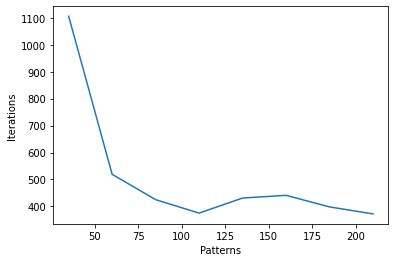

In [30]:
import matplotlib.pyplot as plt

plt.plot(P_range, iteration_values)
plt.ylabel('Iterations')
plt.xlabel('Patterns')
plt.show()